# Continuous Control

---

In this notebook, I present my implementation with the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

Start by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, let's load the environment:

In [2]:
env = UnityEnvironment(file_name='./twenty-agents/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


# PPO Implementation

In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from collections import namedtuple

from ActorCritic import ActorCritic
from Agent import act, calculate_gae_returns, Batcher, learn, trajectory

In [7]:
# Hyperparmeters
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
state_size = brain.vector_observation_space_size

n_episodes = 500
max_steps = 1000
reward_threshold = 30.
lr = 1e-4
batch_size = 64

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
model = ActorCritic(state_size, action_size)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [11]:
total_scores = []

episodes_bar = tqdm(total=n_episodes, desc='Episodes')
step_bar = tqdm(total=max_steps, desc='Steps', leave=False)
for i_episode in range(n_episodes):
   # Reset environment and get initial state
   env_info = env.reset(train_mode=True)[brain_name]
   state = env_info.vector_observations
   done = env_info.local_done
   
   episode_score = 0.
   trajectories = []
   while not any(done):
      # Collect trajectories from current episode
      next_state, done, t = act(env, model, state, brain_name)
      trajectories.append(t)
      episode_score += t.reward.mean()
      state = next_state
      
      step_bar.update(1)
   step_bar.reset()

   # Keep track of total rewards score
   total_scores.append(episode_score)
   
   # Get final value from terminal state
   next_value, _ = model(torch.FloatTensor(state))
   next_value = next_value.detach().cpu().numpy()
   terminal_trajectory = trajectory(state, None, None, None, None, next_value)
   trajectories.append(terminal_trajectory)

   # Calculate advantages via Generalized Advanage Estimation
   processed_trajectories = calculate_gae_returns(trajectories, num_agents=num_agents)
   states, actions, old_log_probs, returns, advantages = map(torch.FloatTensor, zip(*processed_trajectories))

   # Normalize advantages
   advantages = (advantages - advantages.mean())  / (advantages.std() + 1e-7)
   
   # Get random batches from accumulated trajectories
   batcher = DataLoader(
      Batcher(states, actions, old_log_probs, returns, advantages),
      batch_size=batch_size,
      shuffle=True
   )

   # Train actor-critic model
   model.train()
   learn(model, optimizer, batcher)
   
   # Calculate average score and print stats
   average_score = np.mean(total_scores[-100:])
   if i_episode % 50 == 0:
      print(f'Episode {i_episode}/{n_episodes} | Average Score: {round(average_score, 2)}')
   if average_score >= reward_threshold:
      print(f'Environment solved in {i_episode}!')
      torch.save(model.state_dict(), 'checkpoint.pth')
      break
      
   episodes_bar.update(1)
step_bar.close()
episodes_bar.close()

Episode 0/500 | Average Score: 0.24
Episode 50/500 | Average Score: 3.54
Episode 100/500 | Average Score: 6.78
Episode 150/500 | Average Score: 14.31
Episode 200/500 | Average Score: 25.71
Environment solved in 218!



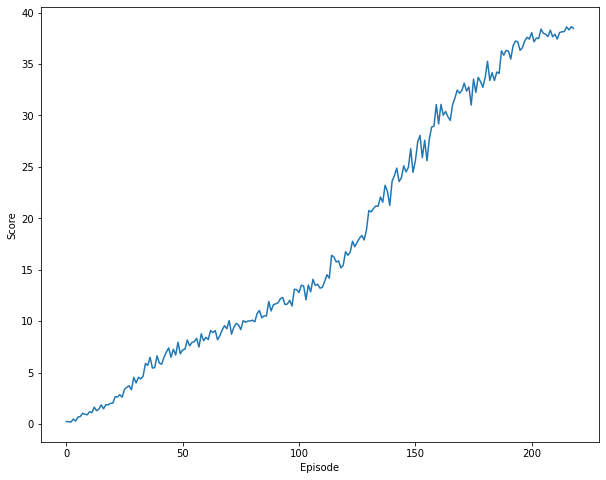

In [12]:
plt.figure(figsize=(10, 8))
plt.plot(total_scores)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.show()

# Test Agent

In [14]:
model = ActorCritic(state_size, action_size)
model.load_state_dict(torch.load('checkpoint.pth'))
model.eval()

ActorCritic(
  (base): Sequential(
    (0): Sequential(
      (0): Linear(in_features=33, out_features=64, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
    )
  )
  (actor_lin): Linear(in_features=64, out_features=4, bias=True)
  (critic_lin): Linear(in_features=64, out_features=1, bias=True)
)

In [15]:
total_scores = []

env_info = env.reset(train_mode=False)[brain_name]
states = env_info.vector_observations
done = env_info.local_done

episode_score = 0.
while not any(done):
   # Get optimal action
   _, dist = model(torch.FloatTensor(state))
   action = dist.sample().detach().cpu().numpy()
   
   # Take step
   env_info = env.step(action)[brain_name]
   next_state = env_info.vector_observations
   rewards = env_info.rewards
   done = env_info.local_done
   episode_score += np.mean(rewards)
   
   state = next_state

print('Total score (averaged over agents) this episode: {}'.format(episode_score))

Total score (averaged over agents) this episode: 38.342499142978475


# Close environment

In [16]:
env.close()